Set up
---

In [ ]:
import numpy as np  
import seaborn as sns 
import matplotlib.pyplot as plt
import os  
import sys
!git clone https://github.com/martomi/roboalgorithms-code

!cp /content/roboalgorithms-code/notebooks/util.py /content
import util


Cloning into 'roboalgorithms-code'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 5), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (19/19), done.


**ADC converter**
---


adc() : convert 

In [ ]:
def max_value(bit_depth: int) -> int:
    """Return max integer value for the specified bit depth"""
    return 2**bit_depth - 1

def adc(milivolts: np.ndarray, bit_depth: int = 8) -> int:
    """Naive A/D converter
    
    milivolts  -- accumulated voltage from a photodiode
    bit_depth  -- target bit depth of the digitized output
    """
    return np.clip(np.around(milivolts), 0, max_value(bit_depth))

def plot_adc_examples():
    """Plot a few interesting examples"""
    plt.figure(figsize=(20, 5))
    x_label = 'Input voltage (mV)'
    y_label = 'Output pixel value'

    plt.subplot(131)
    voltages = np.arange(0, 10, 0.1)
    plt.plot(voltages, adc(voltages))
    plt.title("In supported range")
    plt.xlabel=x_label
    plt.ylabel=y_label 
              

    plt.subplot(132)
    voltages = np.arange(0, 0.5, 0.01)
    plt.plot(voltages, adc(voltages))
    plt.title("Below supported range")
    plt.xlabel=x_label
    plt.ylabel=y_label
              

    plt.subplot(133)
    voltages = np.arange(255, 500, 1)
    plt.plot(voltages, adc(voltages))
    plt.title("Above supported range")
    plt.xlabel=x_label
    plt.ylabel=y_label 
              
    
#plot_adc_examples()

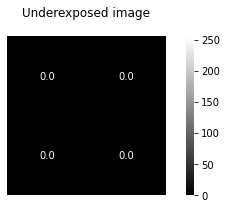

In [ ]:
photodiode_array_milivolts = np.array([0.028, 0.213, 0.234, 0.459])

pixel_values = adc(photodiode_array_milivolts)
util.display_images([pixel_values], titles=["Underexposed image"])

**PGA**
---

pga() : amplify the voltages from the photodiodes

In [ ]:
def pga(milivolts: np.ndarray, gain: float = 1.0) -> float:
    """Naive programmable-gain amplifier
    
    milivolts  -- input voltage from photodiode
    gain       -- ratio output / input
    """
    return gain * milivolts

# Add an amplifier to the same example values from above
#pixel_values = adc(pga(photodiode_array_milivolts, gain=300.0))
#util.display_images([pixel_values], titles=["Amplified image"])

**get_sensor_irradiance**
---

get_sensor_irradiance() : Get a sample sensor irradiance

In [ ]:
def get_sensor_irradiance():
    """Get a sample sensor irradiance
    
    We have an imaging sensor of 2x2 pixels (stored as 1D array)
    The sensor irradiance encodes how many photons
    are hitting the image sensor every second.
    The values are arbitrarily chosen.
    """
    pix11_irradiance = 1122 # photons / second
    pix12_irradiance = 3242 # photons / second
    pix21_irradiance = 1452 # photons / second
    pix22_irradiance = 25031 # photons / second

    return np.array([
        pix11_irradiance, pix12_irradiance,
        pix21_irradiance, pix22_irradiance])

**capture_image and ResponseFunction**
---

img1=capture_image(E=get_sensor_irradiance(), t=1/10, G=linear_crf) : get the picture


In [ ]:
from typing import Callable

ResponseFunction = Callable[[np.ndarray, int], np.ndarray]

def capture_image(E: np.ndarray, t: float, G: ResponseFunction, 
                 bit_depth: int = 8, std_noise: float = 1.0) -> np.ndarray:
    """Simulate capturing an image with exposure time t.
    
    You can specify higher bit_depth for internal processing prior to
    finally converting the image to 8-bit depth before output.

    E         -- sensor irradiance
    t         -- exposure time (seconds)
    G         -- camera response function (CRF)
    bit_depth -- bit depth for A/D converter output and response function input
    std_noise -- standard deviation for the Gaussian noise distribution
    """
    # Non-realistic but simple calculation
    accumulated_milivolts = E * t
    
    # Add the white Gaussian noise
    noise = np.random.normal(0, std_noise, size=len(accumulated_milivolts))
    accumulated_milivolts += noise
    
    image = G(
        adc(pga(accumulated_milivolts), bit_depth), bit_depth
    )
    
    # Always convert to 8-bit depth prior to saving / outputting
    to_8bit_depth = max_value(8) / max_value(bit_depth)
    return np.around(image * to_8bit_depth)

def linear_crf(X: np.ndarray, bit_depth: int) -> np.ndarray:
    """Linear camera response function G(x) = x"""
    return X

Example (noraml case)

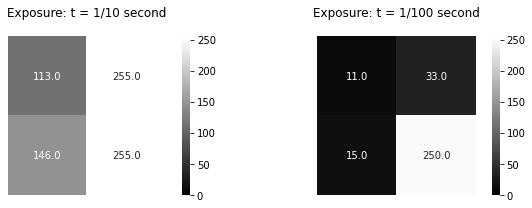

In [ ]:
img1 = capture_image(E=get_sensor_irradiance(), t=1/10, G=linear_crf)
img2 = capture_image(E=get_sensor_irradiance(), t=1/100, G=linear_crf)
util.display_images([img1, img2], 
                    titles=["Exposure: t = 1/10 second", 
                            "Exposure: t = 1/100 second"])

Example (extrem case)

In [ ]:
def get_extreme_sensor_irradiance():
    # Note that the range spans multiple orders of magnitude 
    return np.array([182, 5432, 15329, 252531])

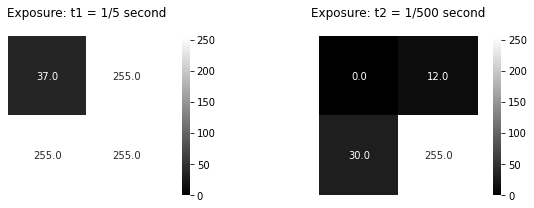

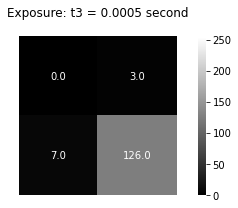

In [ ]:

t1, t2 = 1/5, 1/500
img1 = capture_image(E=get_extreme_sensor_irradiance(), t=t1, G=linear_crf)
img2 = capture_image(E=get_extreme_sensor_irradiance(), t=t2, G=linear_crf)
util.display_images([img1, img2], 
                    titles=["Exposure: t1 = 1/5 second", 
                            "Exposure: t2 = 1/500 second"])
t3 = 1/2000
img3 = capture_image(E=get_extreme_sensor_irradiance(), t=t3, G=linear_crf)
util.display_images([img3],titles=["Exposure: t3 = 0.0005 second"])

**recover_image_irradiance Inverse RF**
---

In [ ]:
InverseResponseFunction = Callable[[np.ndarray], np.ndarray]

def recover_image_irradiance(I: np.ndarray, 
                             t: float, U: InverseResponseFunction) -> np.ndarray:
    """Recover the irradiance from an image that was
    taken with known exposure time t.

    We cannot recover any useful information from 
    oversaturated (255) or undersaturated (0) image 
    intensities. Return 0 in both cases as this helps
    eliminate the need for separate case handling.

    I  -- image (array of image intensities)
    t  -- exposure time (seconds)
    U  -- inverse of the response function
    """
    I[I == 255] = 0 # oversaturated pixels
    return U(I) / t

def linear_inverse_crf(I: np.ndarray) -> np.ndarray:
    """Linear inverse camera response function U(x) = x"""
    return I

In [ ]:
print(f"\nImage irradiance (t = {t1}):")
print(recover_image_irradiance(I=img1, t=t1, U=linear_inverse_crf))
print(f"\nImage irradiance (t = {t2}):")
print(recover_image_irradiance(I=img2, t=t2, U=linear_inverse_crf))
print(f"\nImage irradiance (t = {t3:.4f}):")
print(recover_image_irradiance(I=img3, t=t3, U=linear_inverse_crf))


Image irradiance (t = 0.2):
[185.   0.   0.   0.]

Image irradiance (t = 0.002):
[    0.  6000. 15000.     0.]

Image irradiance (t = 0.0005):
[     0.   6000.  14000. 252000.]


estimate_sensor_irradiance_average
---




In [ ]:
from typing import List

def estimate_sensor_irradiance_average(images: List[np.ndarray], 
                                       exposures: List[float], 
                                       U: InverseResponseFunction) -> np.ndarray:
    """Recover the sensor irradiance
    
    images    -- list of images to use for recovery
    exposures -- corresponding list of exposures
    U         -- inverse response function
    """
    assert len(images) == len(exposures), \
            "The number of images and exposures don't match"
    assert len(images) > 0, "Expected non-empty list of images"
    
    image_size = images[0].shape[0]
    
    irradiance_sum = np.zeros(image_size)
    irradiance_count = np.zeros(image_size)
    for I, t in zip(images, exposures):
        image_irradiance = recover_image_irradiance(I, t, U)
        irradiance_sum += image_irradiance
        # Only non-zero values are observed and contribute to average
        irradiance_count[image_irradiance != 0] += 1

    return np.divide(irradiance_sum, irradiance_count, 
                     out=np.zeros(image_size), 
                     where=irradiance_count != 0)

In [ ]:
[img1, img2, img3]

[array([37.,  0.,  0.,  0.]),
 array([ 0., 12., 30.,  0.]),
 array([  0.,   3.,   7., 126.])]

In [ ]:
estimated_sensor_irradiance = estimate_sensor_irradiance_average(
    [img1, img2, img3], [t1, t2, t3], U=linear_inverse_crf)

util.print_error_to_ground_truth(
    estimated_sensor_irradiance, ground_truth=get_extreme_sensor_irradiance())

Ground-truth:  [   182   5432  15329 252531]
Estimated:  [1.85e+02 6.00e+03 1.45e+04 2.52e+05]
Error (diff):  [  -3. -568.  829.  531.]


In [ ]:
from typing import Tuple, List

ImagesExposuresTuple = Tuple[List[np.ndarray], List[float]]

def generate_sliding_exposure_dataset(
    E: np.ndarray, G: ResponseFunction, bit_depth: int = 8, 
    start_us: int = 40, step_perc: int = 5, number_exposures: int = 220, 
    images_per_exposure: int = 1) -> ImagesExposuresTuple:
    """Generate dataset with sliding exposure values
    
    E                    -- sensor irradiance
    G                    -- camera response function
    bit_depth            -- bit depth for the camera's internal processing
    start_us             -- microseconds for the starting value of the sequence
    step_perc            -- percentage step between subsequent exposure values
    number_exposures     -- number of unique exposure times to generate
    images_per_exposure  -- number of images per exposure time
    """
    def get_exposure_seconds(idx: int) -> float:
        multiplier = (1 + (step_perc / 100)) ** idx
        return round(start_us * multiplier) * 1e-6
    
    images, exposures = [], []
    for exposure_idx in range(number_exposures):
        for _ in range(images_per_exposure):
            t = get_exposure_seconds(exposure_idx)
            images.append(capture_image(E=E, t=t, G=G))
            exposures.append(t)
            
    return images, exposures

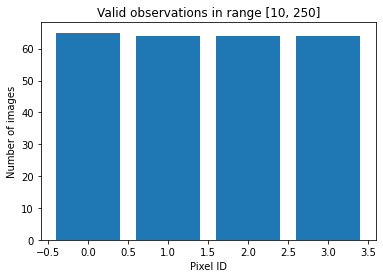

In [ ]:
images, exposures = generate_sliding_exposure_dataset(
            E=get_extreme_sensor_irradiance(), G=linear_crf)

util.display_valid_observations(np.array(images))

estimate_sensor_irradiance_weighted
---

In [ ]:
def estimate_sensor_irradiance_weighted(
    images: List[np.ndarray], exposures: List[float], 
    U: Callable[[np.ndarray], np.ndarray], w: Callable[[int], int]) -> np.ndarray:
    """Estimate the sensor irradiance
    
    The recovered image irradiances are weighted according to the provided
    weighting function. This works best with higher number of images 
    and well-distributed exposure times.
    
    images    -- list of images to use for recovery
    exposures -- corresponding list of exposures
    U         -- inverse response function
    w         -- weighting function
    """
    assert len(images) == len(exposures), \
            "The number of images and exposures don't match"
    assert len(images) > 0, "Expected non-empty list of images"
    
    image_size = images[0].shape[0]
    w_vec = np.vectorize(w)
    
    irradiance_sum = np.zeros(image_size)
    irradiance_count = np.zeros(image_size)
    for I, t in zip(images, exposures):
        weights = w_vec(I)
        image_irradiance = recover_image_irradiance(I, t, U)
        irradiance_sum += weights * image_irradiance
        # Only non-zero values are observed and contribute to average
        irradiance_count[image_irradiance != 0] += weights[image_irradiance != 0]

    return np.divide(irradiance_sum, irradiance_count, 
                     out=np.zeros(image_size), 
                     where=irradiance_count != 0)

In [ ]:
def weighting_debevek_malik(pix_value: int) -> int:
    """Weighting function for recovering irradiance"""
    if pix_value <= 127:
        return pix_value
    if pix_value > 127:
        return 255 - pix_value
def weighting_squared(pix_value: int) -> int:
    return weighting_debevek_malik(pix_value) ** 2

In [ ]:
images, exposures = generate_sliding_exposure_dataset(
            E=get_extreme_sensor_irradiance(), G=linear_crf)

recovered_sensor_irradiance = estimate_sensor_irradiance_weighted(
    images, exposures, U=linear_inverse_crf, w=weighting_squared)
util.print_error_to_ground_truth(
    recovered_sensor_irradiance, ground_truth=get_extreme_sensor_irradiance())

Ground-truth:  [   182   5432  15329 252531]
Estimated:  [1.83808981e+02 5.42748355e+03 1.53324680e+04 2.53546889e+05]
Error (diff):  [   -1.80898053     4.51645478    -3.46795143 -1015.88907198]


HDR display (linear, gamma, log)
---

In [ ]:
#1 linera
def normalize_255(image: np.ndarray) -> np.ndarray:
    """Normalize values withing range [0, 255]"""
    min_i, max_i = min(image), max(image)
    assert min_i < max_i, "Range cannot be normalized (min == max)"
    return np.around((image - min_i) * (255 / (max_i - min_i)))

#2 gamma
def gamma(X: np.ndarray) -> np.ndarray:
    assert all(X >= 0) and all(X <= 1)
    return X**(1/2.2)

def apply_gamma(E: np.ndarray, bit_depth: int = 8):
    return gamma(E / max_value(bit_depth)) * max_value(bit_depth)

Example

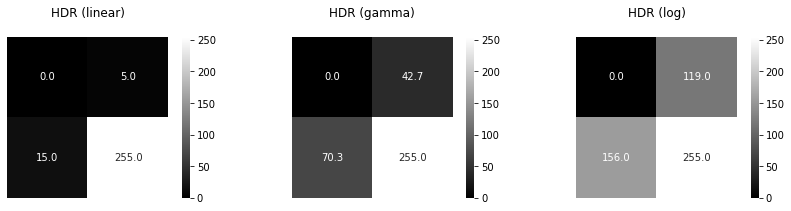

In [ ]:
hdr_linear = normalize_255(recovered_sensor_irradiance)
hdr_gamma = apply_gamma(normalize_255(recovered_sensor_irradiance))
hdr_log = normalize_255(np.log(recovered_sensor_irradiance + 1))

util.display_images([hdr_linear, hdr_gamma, hdr_log], titles=["HDR (linear)", "HDR (gamma)", "HDR (log)"])

**Non-linear CRF** single pixel
---

In [ ]:
U = np.array([0.] * 256)

def generate_crf_calibration_dataset(
    E: np.ndarray, G: Callable[[np.ndarray, int], np.ndarray], 
    bit_depth: int = 8, start_ms: int = 1, end_ms: int = 201, 
    step_ms: int = 1, images_per_exposure: int = 1) -> ImagesExposuresTuple:
    """Generate dataset with sliding exposure values in the specified range
    
    E                    -- sensor irradiance
    G                    -- camera response function
    bit_depth            -- bit depth for the A/D converter of the camera
    start_ms             -- start value (ms) for the range of exposure values
    end_ms               -- end value (ms) for the range of exposure values
    step_ms              -- step size (ms) for the range of exposure values
    images_per_exposure  -- number of images per exposure time
    """
    
    exposures = [x / 1e3 for x in range(start_ms, end_ms, step_ms)]
    exposures *= images_per_exposure

    images = []
    for t in exposures:
        images.append(capture_image(E=E, t=t, G=G, bit_depth=bit_depth))
    
    return images, exposures

Example1: linear crf (1 image per exposure)

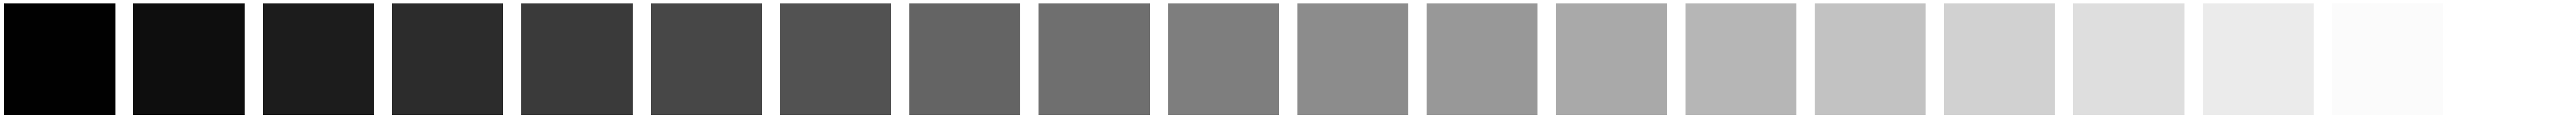

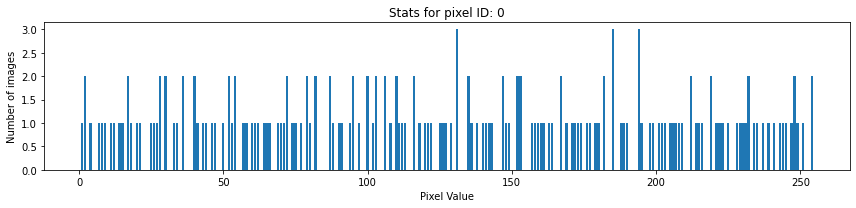

In [ ]:
#generate dataset
single_pixel_irradiance = np.array([1381])
images, exposures = generate_crf_calibration_dataset(
    E=single_pixel_irradiance, G=linear_crf)
util.display_images(images[0::10], shape=(1,1), annot=False)
util.display_observations_distribution(np.array(images))

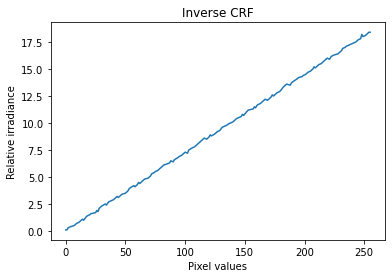

In [ ]:
#recover 
def recover_U_single_pixel(exposures, images):
    # Define an arbitrary (relative) sensor irradiance 
    # Expected to be wrong by a constant factor X
    sensor_irradiance = np.array([100])
    
    # Initialize the inverse function U to 0s
    U = np.array([0.] * 256)

    for t, image in zip(exposures, images):
        pixel_value = int(image[0])
        if pixel_value == 255 or pixel_value == 0:
            # Skip under- or overexposed pixels
            continue
        accumulated_photons = t * sensor_irradiance[0]
        U[pixel_value] = accumulated_photons
    
    return U

#interpolate the graph
def interpolate_missing_values(U):
    observed_intensity = np.zeros(len(U), dtype=bool)
    observed_intensity[U != 0.0] = True
    U[~observed_intensity] = np.interp(
        (~observed_intensity).nonzero()[0], 
        observed_intensity.nonzero()[0], 
        U[observed_intensity])
    return U


util.plot_inverse_crf(
    interpolate_missing_values(
        recover_U_single_pixel(exposures, images)))

Example 2: linear crf (multiple images per exposeure)

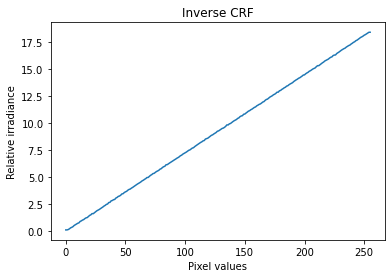

In [ ]:
# Create a dataset with multiple images for each exposure time
images, exposures = generate_crf_calibration_dataset(
    E=single_pixel_irradiance, G=linear_crf, images_per_exposure=20)

def recover_U_single_pixel_average(exposures, images):
    sensor_irradiance = np.array([100])
    
    U_sum = np.array([0.] * 256)
    U_count = np.array([0] * 256)

    for t, image in zip(exposures, images):
        pixel_value = int(image[0])
        if pixel_value == 255 or pixel_value == 0:
            # Skip under- or overexposed pixels
            continue
        accumulated_photons = t * sensor_irradiance[0]
        
        # Sum all observations for specific pixel value
        U_sum[pixel_value] += accumulated_photons
        U_count[pixel_value] += 1
      
    # Calculate the average 
    observed_intensity = np.zeros(len(U_sum), dtype=bool)
    observed_intensity[U_count != 0] = True
    
    return np.divide(U_sum, U_count, out=np.zeros_like(U_sum), 
                     where=observed_intensity)

recovered_inverse_crf_linear = interpolate_missing_values(
                    recover_U_single_pixel_average(exposures, images))

util.plot_inverse_crf(recovered_inverse_crf_linear)

Example 3: Gamma CRF  

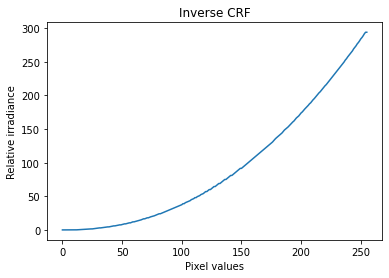

In [ ]:
images, exposures = generate_crf_calibration_dataset(
    E=single_pixel_irradiance, G=apply_gamma, images_per_exposure=20, bit_depth=12,
    start_ms=1, end_ms=3001, step_ms=15)

recovered_inverse_crf_gamma = interpolate_missing_values(
    recover_U_single_pixel_average(exposures, images))
util.plot_inverse_crf(recovered_inverse_crf_gamma)

Multiple pixels
---

In [ ]:
def recover_U(E: np.ndarray, exposures: List[float], images: List[np.ndarray]):
    """Attempt to recover the inverse CRF (U)
    
    Calculation based on the formula U(I(x)) = t * E(x)
    where I(x), t and E(x) are given as arguments.
    
    All observations for a given I(x) are summed up and 
    the average is calculated. Non-observed values are interpolated.
    
    E          -- sensor irradiance
    exposures  -- list of exposure times t (seconds)
    images     -- images 
    """
    U_sum = np.array([0.] * 256)
    U_count = np.array([0] * 256)

    for t, image in zip(exposures, images):
        for i in range(len(image)):
            pixel_value = int(image[i])
            if pixel_value == 255 or pixel_value == 0:
                continue # Skip under- or overexposed pixels
            accumulated_photons = t * E[i]

            # Sum all observations for specific pixel value
            U_sum[pixel_value] += accumulated_photons
            U_count[pixel_value] += 1
      
    # Calculate U as the average of all observations
    observed_intensity = np.zeros(len(U_sum), dtype=bool)
    observed_intensity[U_count != 0] = True
    U = np.divide(U_sum, U_count, out=np.zeros_like(U_sum), 
                  where=observed_intensity)
    
    return interpolate_missing_values(U)

def recover_U_and_E(exposures, images, iterations=5):
    """Attempt to solve for both the inverse CRF and the sensor irradiance
    
    Given a dataset, perform a number of iterations by alternatingly solving 
    for U(x) and E(x) to check if they can converge to a solution.
    """
    E = np.array([100] * len(images[0]))
    U = np.array([0.] * 256)

    response_function = lambda x: U[int(x)]

    U_list = []
    E_list = []
    for _ in range(iterations):
        U = recover_U(E, exposures, images)
        U_list.append(U)
        E = estimate_sensor_irradiance_weighted(
            images, exposures, 
            U=np.vectorize(response_function), 
            w=weighting_debevek_malik)
        E_list.append(E)
    
    return U_list, E_list

Examples

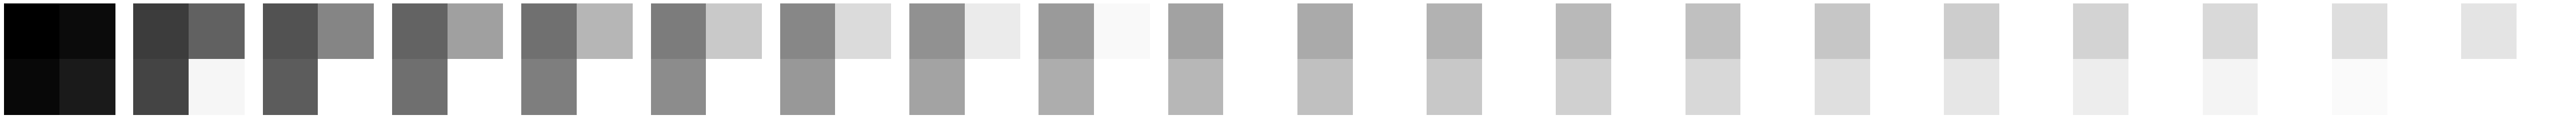

In [ ]:
#Generation
images, exposures = generate_crf_calibration_dataset(
    E=get_sensor_irradiance(), 
    G=apply_gamma, 
    images_per_exposure=5, 
    bit_depth=12,
    start_ms=1, 
    end_ms=3001, 
    step_ms=15)

util.display_images(images[0:200:10], annot=False)


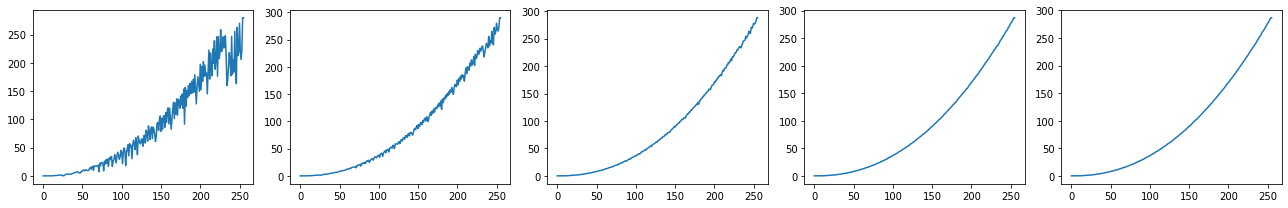

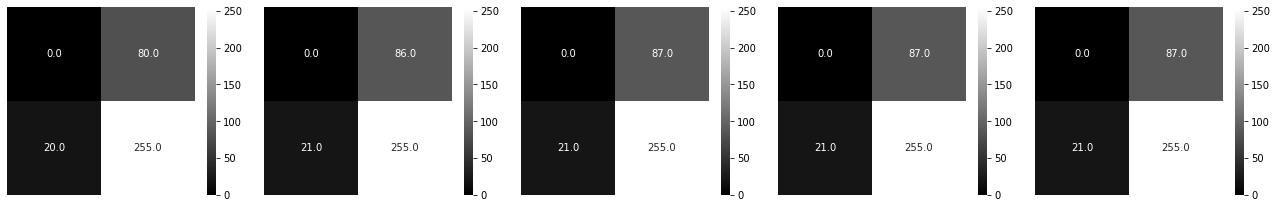

In [ ]:
# iteration = 5
U_list, E_list = recover_U_and_E(exposures, images, iterations = 5)
util.plot_multiple_inverse_crf(U_list)
util.display_images([normalize_255(np.log(E + 1)) for E in E_list])


In [ ]:
print("Normalized Ground-truth: ", normalize_255(get_sensor_irradiance()))
print("Normalized Estimate: ", normalize_255(E_list[-1]))
print("Error: ", normalize_255(
    get_sensor_irradiance()) - normalize_255(E_list[-1]))

Normalized Ground-truth:  [  0.  23.   4. 255.]
Normalized Estimate:  [  0.  23.   4. 255.]
Error:  [0. 0. 0. 0.]


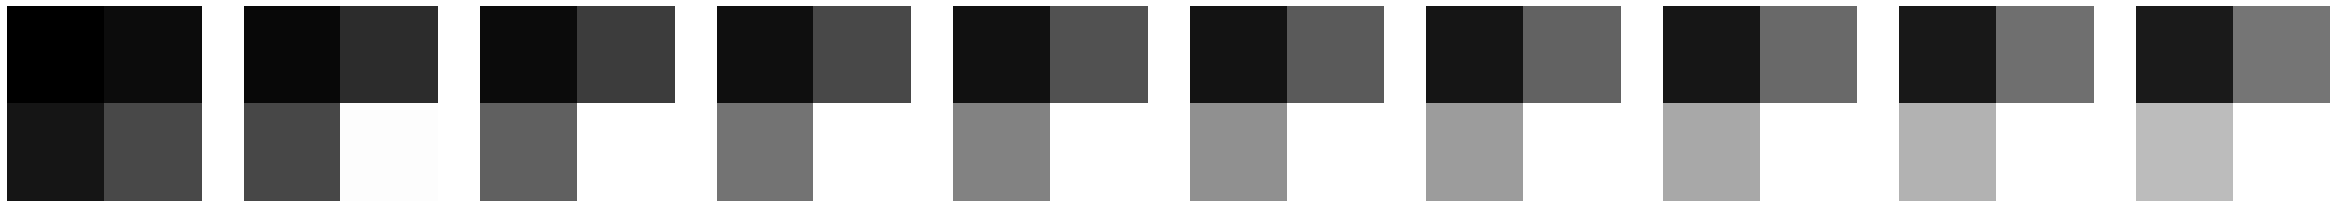

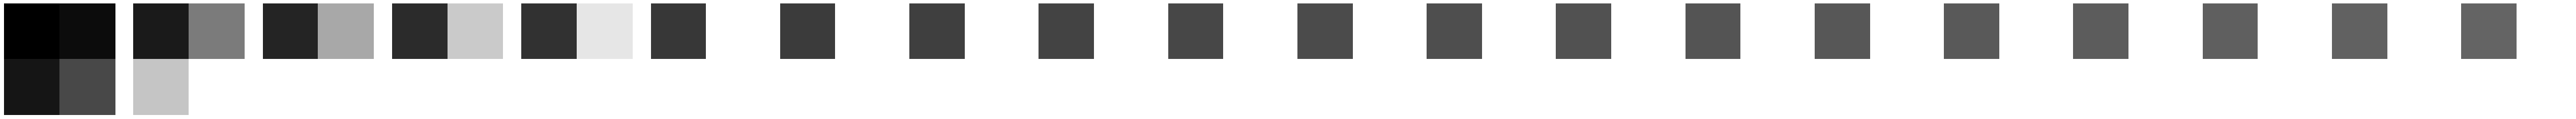

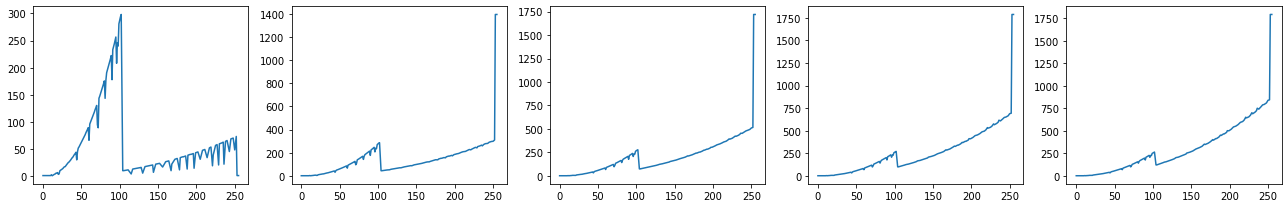

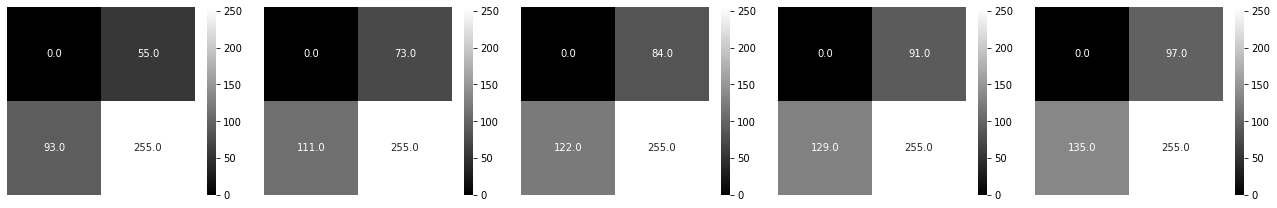

In [ ]:
#extreme data set; iteration =5 does not work
images, exposures = generate_crf_calibration_dataset(
    E=np.array(get_extreme_sensor_irradiance()), G=apply_gamma, 
    images_per_exposure=5, bit_depth=12,
    start_ms=1, end_ms=3001, step_ms=15)

util.display_images(images[0:10], annot=False)
util.display_images(images[0:200:10], annot=False)

U_list, E_list = recover_U_and_E(exposures, images, iterations=5);
util.plot_multiple_inverse_crf(U_list)
util.display_images([normalize_255(np.log(E + 1)) for E in E_list])

Normalized Ground-truth:  [  0.   5.  15. 255.]
Normalized Estimate:  [  0.   5.  15. 255.]
Error:  [0. 0. 0. 0.]


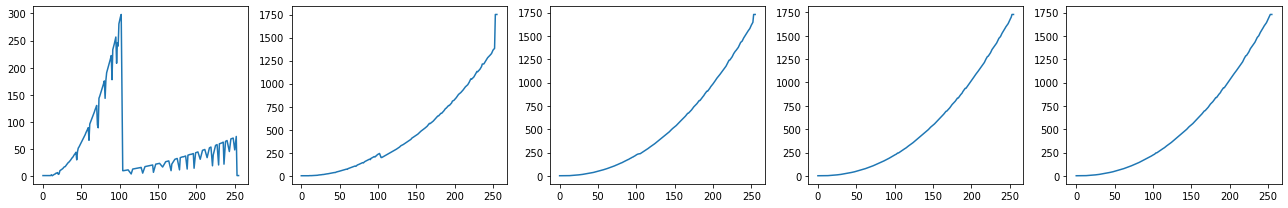

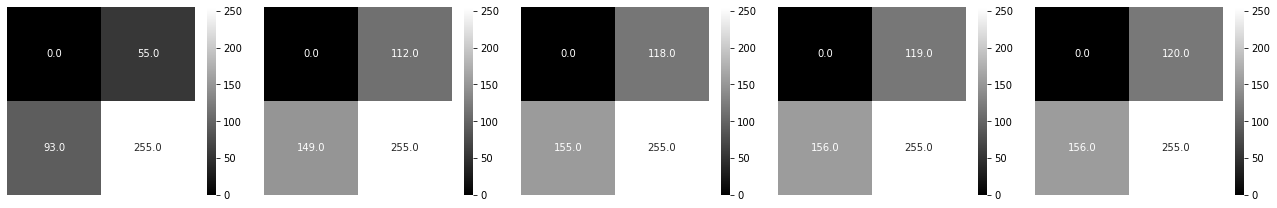

In [ ]:
U_list, E_list = recover_U_and_E(exposures, images, iterations=50);
util.plot_multiple_inverse_crf(U_list[::10])
util.display_images([normalize_255(np.log(E + 1)) for E in E_list[::10]])

print("Normalized Ground-truth: ", normalize_255(get_extreme_sensor_irradiance()))
print("Normalized Estimate: ", normalize_255(E_list[-1]))
print("Error: ", normalize_255(
    get_extreme_sensor_irradiance()) - normalize_255(E_list[-1]))

**Testing on real dataset**
---

In [ ]:
import os
from skimage import io
from skimage.measure import block_reduce

def load_dataset(path: str, with_downsample: bool = True,
                 block_size: Tuple[int, int] = (10, 10)):
    """Load dataset from the specified path
    
    Subsambling the image size in order reduce the execution time
    of the (unoptimized) example algorithms
    
    path              -- path to the dataset
    with_downsample   -- enable/disable downsampling
    block_size        -- block size that gets sampled down to 1 pixel
    """
    image_folder = os.path.join(path, "images")
    exposure_file = os.path.join(path, "times.txt")
    gt_file = os.path.join(path, "pcalib.txt")

    exposures, images = [], []
    shape_original, shape_output = None, None
    
    def downsample(image):
        """Do max sampling in order to avoid bias from overexposed values"""
        return block_reduce(image, block_size=block_size, func=np.max, cval=0)
    
    with open(exposure_file, "r") as f:
        for line in f.readlines():
            # Parse meta information and append to output lists
            [idx, ts, exposure_ms] = line.strip().split(" ")
            exposures.append(float(exposure_ms) * 1e-3)
            
            # Load and downsamble image
            image_original = io.imread(os.path.join(
                image_folder, idx + ".jpg"), as_gray=True)
            image_output = downsample(image_original) \
                if with_downsample else image_original
            images.append(image_output.flatten())
  
            if shape_output is None:
                shape_original = image_original.shape
                shape_output = image_output.shape
    
    print("Original size: " + str(shape_original) + 
          " Output size: " + str(shape_output))
    
    ground_truth = None
    with open(gt_file, 'r') as f:
        ground_truth = [float(i) for i in f.readline().strip().split()]
    
    return exposures, images, shape_output, ground_truth

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: ignored

Linear Response Dataset

In [ ]:
#load the dataset and show 
exposures, images, shape, ground_truth = load_dataset(
    path="/content/drive/MyDrive/testing_file/calib_narrow_sweep3")

util.display_images(images[::200], shape=shape, annot=False)


In [ ]:
#interation = 3 
U_list, E_list = recover_U_and_E(exposures, images, iterations=3);
util.plot_multiple_inverse_crf(U_list)
util.display_images([normalize_255(np.log(E + 1)) for E in E_list], 
                    shape=shape, annot=False)

Gamma Response Dataset

In [ ]:
#load the dataset and show
exposures, images, shape, ground_truth = load_dataset(
    path="/content/drive/MyDrive/testing_file/calib_narrowGamma_sweep3")

util.display_images(images[::200], shape=shape, annot=False)


In [ ]:
#interation = 3
U_list, E_list = recover_U_and_E(exposures, images, iterations=3);
util.plot_multiple_inverse_crf(U_list)
util.display_images([normalize_255(np.log(E + 1)) for E in E_list], 
                    shape=shape, annot=False)